In [51]:
#%pip install networkx==1.11
#%pip uninstall networkx && pip install networkx
#%pip install scipy

# FBox

A fix : probleme il prend toujours le dernier sinon rien
et bcp de probleme avec matlab voir commentaires

In [52]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.io import savemat, loadmat
import os

import pylab

In [53]:
def plot_graph(A):
    G = nx.DiGraph()
    for count,value in enumerate(A):
        for count2, value2 in enumerate(value):
            if (value2 != 0):
                G.add_edges_from([(str(count), str(count2))], weight=value2)

    edge_labels=dict([((u,v,),d['weight'])
                    for u,v,d in G.edges(data=True)])

    pos=nx.spring_layout(G)
    
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nx.draw(G,pos,edge_cmap=plt.cm.Reds,with_labels = True)
    #nx.draw(G,pos,edge_cmap=plt.cm.Reds,with_labels = True,connectionstyle='arc3, rad = 0.3')
    pylab.show()

In [54]:
#==========   Initialisation
pcthresh = 1
degthresh = 2
neigs = 3#Utilite enleve

#[!] Il check ligne ou colonne (car matlab inverse)??? actuellement ligne ???
graph = [
    [0, 5 ,2 ,4],
    [1, 0, 5, 3],
    [ 5 ,5 ,5, 0],
    [ 0, 0, 0, 0],
]

graph = np.array(graph)
#graph = np.transpose(graph)
#graph[graph>0] = 1

adj = csc_matrix(graph, dtype=float)
#A = csc_matrix([[1, 0, 0], [5, 0, 2], [0, -1, 0], [0, 0, 3]], dtype=float)

  (1, 0)	1.0
  (2, 0)	5.0
  (0, 1)	5.0
  (2, 1)	5.0
  (0, 2)	2.0
  (1, 2)	5.0
  (2, 2)	5.0
  (0, 3)	4.0
  (1, 3)	3.0
attention les edges s overlap


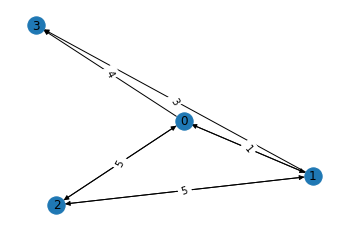

In [55]:
#============ On affiche le graphe de liens

print(adj)
print("attention les edges s overlap")
plot_graph(graph)

Probleme : A = graph ou A=adj

In [56]:
#Le A de matlab est adj ou graph ???? (les deux marchent sous matlab mais res diff)
A = adj.toarray()

In [57]:
#========= Fonction svd

#Difference entre les deux : svds et svd quasi pareil
#Matlab et python : matlab prend le max et fais pas le meme calcul que python (cf ci dessous)

#https://stackoverflow.com/questions/50930899/svd-command-in-python-v-s-matlab
def m_svds(A,neigs):
    m,n = A.shape
    U, sdiag, VH = np.linalg.svd(A)
    S = np.zeros((m, n))
    np.fill_diagonal(S, sdiag)
    V = VH.T.conj()  # if you know you have real values only you can leave out the .conj()
    return U,S,V

#Ici S est le meme que celui de matlab mais u et v pas pareil
def m_svds2(A,neigs):
    m,n = A.shape
    U,S,V = np.linalg.svd(A)
    B = np.zeros(A.shape)
    for i in range(m) :
        for j in range(n) :
            if i == j :
                 B[i,j] = S[j]
    return U,B,V

#u, s, v = svds(A, k=neigs,which="LM")
u,s,v = m_svds2(A,neigs)

#A check
indegs = np.sum(A, 1-1)
outdegs = np.sum(A, 2-1)
rec_indegs = np.sum((v * s) ** 2, 2-1)
rec_outdegs = np.sum((u * s) ** 2, 2-1)



In [58]:
#========== Conversion matlab python

def unique(a):
    return np.unique(np.array(a))

def sparse(a,b):
    return np.zeros((a,b))

def find(cond):
    return np.where(cond)

#A check
def prctile(X,p):
    return np.percentile(X,p)

In [59]:
#Si A=graph car np casse les c**
'''
indegs = indegs.tolist()[0]
outdegs = outdegs.tolist()[0]
rec_indegs = rec_indegs.tolist()
rec_outdegs = rec_outdegs.tolist()

indegs = np.array(indegs)
outdegs = np.array(outdegs)
'''

'\nindegs = indegs.tolist()[0]\noutdegs = outdegs.tolist()[0]\nrec_indegs = rec_indegs.tolist()\nrec_outdegs = rec_outdegs.tolist()\n\nindegs = np.array(indegs)\noutdegs = np.array(outdegs)\n'

In [60]:
#========== Fonction culprits

q = unique(indegs)
lq = len(q)
trackpct_indegs = sparse(lq,2)
for i in range(0,lq):
    deg = q[i]
    trackpct_indegs[i,0] = deg
    indices = find(indegs == deg)
    vsub = v[indices,:]
    rdegs = np.sum((vsub * s) ** 2, 2-1)
    trackpct_indegs[i,1] = prctile(rdegs,pcthresh)

q = unique(outdegs)
lq = len(q)
trackpct_outdegs = sparse(lq,2)
for i in range(0,lq):
    deg = q[i]
    trackpct_outdegs[i,0] = deg
    indices = find(outdegs == deg)
    usub = u[indices,:]
    rdegs = np.sum((usub * s) ** 2, 2-1)
    trackpct_outdegs[i,1] = prctile(rdegs,pcthresh)

nnodes = len(indegs)

#On met [0] car il englobe dans des array ... encore
isub = find(indegs > degthresh)[0]
osub = find(outdegs > degthresh)[0]


iculprits = []
oculprits = []

for node in isub:
    cond1 =rec_indegs[node]
    f = find(trackpct_indegs[:,0] == indegs[node])
    f = f[0][0]#On enleve les liste de liste car il englobe ds array et sa casse les c**
    cond2 =trackpct_indegs[f,1]
    if  cond1<cond2 :
        iculprits.append((node,indegs[node]))#Resultat de forme : (ind chelou,degre chelou)

for node in osub:
    cond1 = rec_outdegs[node]
    f = find(trackpct_outdegs[:,0] == outdegs[node])
    f = f[0][0]#On enleve les liste de liste car il englobe ds array et sa casse les c**
    cond2 = trackpct_outdegs[f,1]
    if cond1 < cond2:
        oculprits.append((node,outdegs[node]))#Resultat de forme : (ind chelou,degre chelou)

ictr = len(iculprits)
octr = len(oculprits)

print("number of susp i : ",ictr)
print(iculprits)
print("number of susp o:",octr)
print(oculprits)
    

number of susp i :  1
[(3, 7.0)]
number of susp o: 0
[]


# Pseudo-code implémentation

In [121]:
mat = loadmat('../data_out/data_amz.mat')
adj = mat['M'].asfptype()
adj = adj.transpose()

In [126]:
def fbox(A, k, t):
    userCulprits   = []
    objectCulprits = []
    outDegrees     = np.sum(A, 0)
    inDegrees      = np.sum(A, 1)
    U, S, V        = svds(A, k=k,which="LM",return_singular_vectors=True)
    

    print("nb out degre 0 (5)",outDegrees[0,1])# doit etre a 5
    print("nb out degre 0 (1)",inDegrees[1,0])# doit etre a 1

    recOutDegs = np.square(np.linalg.norm(U*S, axis=1))
    recInDegs  = np.square(np.linalg.norm(np.transpose(V)*S, axis=1))
    
    uniqueOutDegrees = np.unique(np.array(outDegrees))
    uniqueInDegrees  = np.unique(np.array(inDegrees))
    

    for od in uniqueOutDegrees:
        nodeSet = np.where(uniqueOutDegrees == od)[0]
        recOutDegSet = recOutDegs[nodeSet]
        recThreshold = np.percentile(recOutDegSet, t)
        for n in nodeSet:
            if(recOutDegs[n] <= recThreshold):
                userCulprits.append(n)
                #userCulprits.append((n,recOutDegs[n]))
            
    for ind in uniqueInDegrees:
        nodeSet = np.where(uniqueInDegrees == ind)[0]
        recInDegSet = recInDegs[nodeSet]
        recThreshold = np.percentile(recInDegSet, t)
        for n in nodeSet:
            if(recInDegs[n] <= recThreshold):
                objectCulprits.append(n)
                #objectCulprits.append((n,recInDegs[n]))
    
    return userCulprits, objectCulprits

In [127]:
pcthresh = 2
neigs = 50#Utilite enleve


userCulprits, objectCulprits = fbox(adj, neigs, pcthresh)
print("user culprits : ",len(userCulprits))
print(userCulprits)
print("object culprits : ",len(objectCulprits))
print(objectCulprits)